## Configuração Inicial

In [11]:
import google.generativeai as genai
from dotenv import load_dotenv
import os
import json
import pandas as pd
from google.generativeai.types import HarmCategory, HarmBlockThreshold

load_dotenv()

google_api_key = os.getenv("GOOGLE_API_KEY")
model = genai.GenerativeModel("gemini-1.5-flash")

##  4 - Meta Prompting para Análise de Sentimento

In [12]:
positivas = [
    "A vida é boa",
    "O futuro é promissor",
    "A gente é muito feliz",
    "Adoro quando tudo dá certo.",
    "Esse é o melhor momento da minha vida."
]

neutras = [
    "A decisão está tomada, vamos ver o que acontece.",
    "Isso não faz muita diferença para mim.",
    "Por mim, tanto faz",
    "Pode ser de qualquer maneira"
]

negativas = [
    "É muito ruim ter que fazer isso",
    "Essa pessoa é muito chata",
    "Essa situação é insuportável.",
    "Estou extremamente decepcionado com isso."
]

In [ ]:
import requests
from bs4 import BeautifulSoup

def coletar_manchetes(url):
    header = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36", "accept": "application/json"}
    resposta = requests.get(url, headers=header)
    resposta.raise_for_status() 

    soup = BeautifulSoup(resposta.text, 'html.parser')
        
    artigos = soup.find_all('article')
    manchetes = []
    for artigo in artigos:
        tag_h2 = artigo.find('h2')
        if tag_h2:
            manchetes.append(tag_h2.text.strip())
        
    return manchetes

url_tecnoblog = "https://tecnoblog.net/?s=+" # URL do Tecnoblog no campo de procura digita " " -> espaço.
manchetes = coletar_manchetes(url_tecnoblog)

In [63]:
prompt = f"""
Você é um especialista em comunicação humana e marketing, especializado em análise de sentimentos.
Você precisa classificar falas de um programa de desenho animado como negativas, neutras e positivas, conforme definido abaixo:
- positivas: falas felizes, construtivas, esperançosas, alegres e semelhantes.
- negativas: falas tristes, destrutivas, desesperançosas, agressivas e semelhantes.
- neutras: falas indiferentes, objetivas, formais e aquelas que não se classificam nem como positivas nem como negativas.

Algumas falas previamente classificadas deste programa estão listadas aqui:

# Positive:
{ '- '.join(positivas) }


# Negative:
{ '- '.join(negativas) }


# Neutral:
{ '- '.join(neutras) }

Com base nessas informações, responda em JSON com a classificação das seguintes falas como positivas, negativas ou neutras.
Retorne nesse modelo:
[
    "line": "dad weve been robbed",
    "sentiment": "negative"
]


{ '- '.join(manchetes) }

"""

response = model.generate_content(prompt)
print(response.text)

```json
[
  {
    "line": "Galaxy S23 Ultra tem menor preço histórico na Black Friday da Amazon",
    "sentiment": "positive"
  },
  {
    "line": "Windows 11 24H2 está fazendo alguns jogos da Ubisoft travarem",
    "sentiment": "negative"
  },
  {
    "line": "Galaxy Tab S9 FE+ tem menor preço em meses na Black Friday do Mercado Livre",
    "sentiment": "positive"
  },
  {
    "line": "Como fazer remix no Instagram? Saiba usar o vídeo de outra pessoa no seu Reels",
    "sentiment": "neutral"
  },
  {
    "line": "Como usar o backup criptografado do WhatsApp? Saiba ativar ou desativar a proteção da cópia de segurança",
    "sentiment": "neutral"
  },
  {
    "line": "Zeenix Lite: PC portátil da TecToy finalmente entra em pré-venda",
    "sentiment": "positive"
  },
  {
    "line": "Bluesky já tem golpes com sites falsos e promessa de criptomoedas",
    "sentiment": "negative"
  },
  {
    "line": "Mozilla teme que afastar Chrome do Google prejudique navegadores menores",
    "sentiment

<Axes: xlabel='# falas', ylabel='Sentimento'>

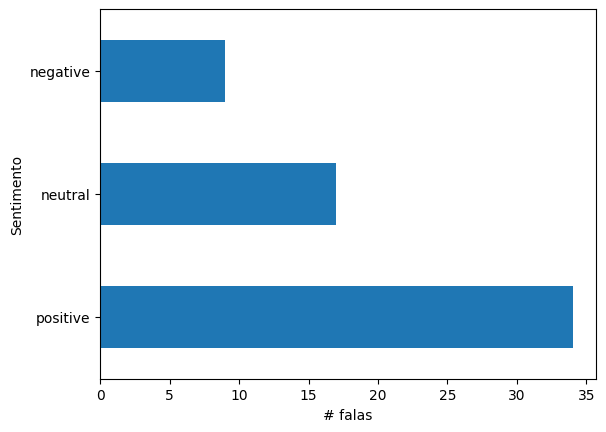

In [ ]:
sentiments = json.loads(response.text.replace("```json\n",'').replace("\n```",''))
sentiments = pd.DataFrame().from_dict(sentiments)
sentiments.columns = ['normalized_text', 'sentiment']
sentiments.sentiment.value_counts().plot.barh(xlabel='# falas', ylabel='Sentimento')




## Há muito mais resultado positivo do que negativo. Tendo o meio preenchido por neutros.


## 5 - Base de dados The Simpsons

In [13]:
import pandas as pd

df_script = pd.read_csv('./data/simpsons_script_lines.csv', low_memory=False)
df_episodes = pd.read_csv('./data/simpsons_episodes.csv', low_memory=False)
df_characters = pd.read_csv('./data/simpsons_characters.csv', low_memory=False)
df_locations = pd.read_csv('./data/simpsons_locations.csv', low_memory=False)

df_script.set_index('id', inplace=True)
df_characters['id'] = df_characters['id'].astype(str)

df_characters = df_characters.add_prefix('character_')
df_locations = df_locations.add_prefix('location_')
df_episodes = df_episodes.add_prefix('episode_')

data = (
    df_script.merge(df_episodes, left_on='episode_id', right_on='episode_id')
             .merge(df_characters, left_on='character_id', right_on='character_id', how='left')
             .merge(df_locations, left_on='location_id', right_on='location_id', how='left')
)


assert data.shape[0] == df_script.shape[0]

In [20]:
data.head().T

0  \
episode_id                                                                     32   
number                                                                        209   
raw_text                        Miss Hoover: No, actually, it was a little of ...   
timestamp_in_ms                                                            848000   
speaking_line                                                                true   
character_id                                                                  464   
location_id                                                                   3.0   
raw_character_text                                                    Miss Hoover   
raw_location_text                                   Springfield Elementary School   
spoken_words                    No, actually, it was a little of both. Sometim...   
normalized_text                 no actually it was a little of both sometimes ...   
word_count                                                                     31   
episode_image_url               http://static-media.fxx.com/img/FX_Networks_-_...   
episode_imdb_rating                                                           8.5   
episode_imdb_votes                                                         1684.0   
episode_number_in_season                                                       19   
episode_number_in_series                                                       32   
episode_original_air_date                                              1991-04-25   
episode_original_air_year                                                    1991   
episode_production_code                                                      7F19   
episode_season                                                                  2   
episode_title                                                   Lisa's Substitute   
episode_us_viewers_in_millions                                               17.7   
episode_video_url                 http://www.simpsonsworld.com/video/288011331912   
episode_views                                                             52770.0   
character_name                                                        Miss Hoover   
character_normalized_name                                             miss hoover   
character_gender                                                                f   
location_name                                       Springfield Elementary School   
location_normalized_name                            springfield elementary school   

                                                                                1  \
episode_id                                                                     32   
number                                                                        210   
raw_text                        Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?   
timestamp_in_ms                                                            856000   
speaking_line                                                                true   
character_id                                                                    9   
location_id                                                                   3.0   
raw_character_text                                                   Lisa Simpson   
raw_location_text                                   Springfield Elementary School   
spoken_words                                               Where's Mr. Bergstrom?   
normalized_text                                               wheres mr bergstrom   
word_count                                                                      3   
episode_image_url               http://static-media.fxx.com/img/FX_Networks_-_...   
episode_imdb_rating                                                           8.5   
episode_imdb_votes                                                         1684.0   
episode_number_in_season                                                       19   

In [4]:
import tiktoken

def estimar_tokens(texto):
    encoder = tiktoken.get_encoding("cl100k_base")  # Exemplo de codificação
    # encoder = tiktoken.get_encoding("gpt-4o")  # Exemplo de codificação
    tokens = encoder.encode(texto)
    return tokens

# text = (data[(data.episode_season == 2) &
#           (data.episode_id == 32)].sort_values('number')
# )
# text['n_tokens'] = text.normalized_text.fillna('').apply(lambda x: len(estimar_tokens(x)))

# print(text['n_tokens'].sum())


X = data.dropna(subset='normalized_text').copy()
X['n_tokens'] = X.normalized_text.fillna('').apply(lambda x: len(estimar_tokens(x)))

print(X['n_tokens'].mean()) # Média de tokens por episódio

X['n_tokens'].unique()

# X.columns
ep = X.groupby('episode_id')['n_tokens'].mean()
temp = X.groupby('episode_season')['n_tokens'].mean() # Média de tokens por temporada

print(ep.max()) # ep com maois token
print(temp.max()) # temp com mais token 

NameError: name 'data' is not defined

In [90]:
cols = ['episode_imdb_rating', 'episode_views']
episode_stats = data[cols].drop_duplicates()

episode_stats.to_csv('./data/series_data.csv', sep=';', index=None)

prompt = f"""
    You are a data scientist specialized in analysing entertainment content. You are working on the show series
"The Simpsons", investigating patterns in the series series_data. 
How can we evaluate the relationship between episode ratings ('episode_imdb_rating')
and audiences ('episode_views') in "./data/series_data.csv", considering it a CSV file
splitted by ';' with columns:

- episode_imdb_rating: episode with the IMDB rating 
- episode_views: total number of episode views.

Implement the analysis described below in python.
Output only the code, no need for explanations.
## ANALYSIS
Determine if there is a correlation between episode ratings (IMDB) and viewership (and total views). Calculate the Pearson correlation coefficient between 'episode_imdb_rating' and 'episode_views'. Visualize the relationship using only scatter plots with matplotlib.
"""

response = model.generate_content(prompt)
print(response.text)

```python
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

series_data = pd.read_csv("./data/series_data.csv", sep=";")
correlation, p_value = pearsonr(series_data['episode_imdb_rating'], series_data['episode_views'])

plt.figure(figsize=(8, 6))
plt.scatter(series_data['episode_imdb_rating'], series_data['episode_views'])
plt.xlabel('Episode IMDB Rating')
plt.ylabel('Episode Views')
plt.title(f'Episode Rating vs. Views (Pearson Correlation: {correlation:.2f})')
plt.show()

```



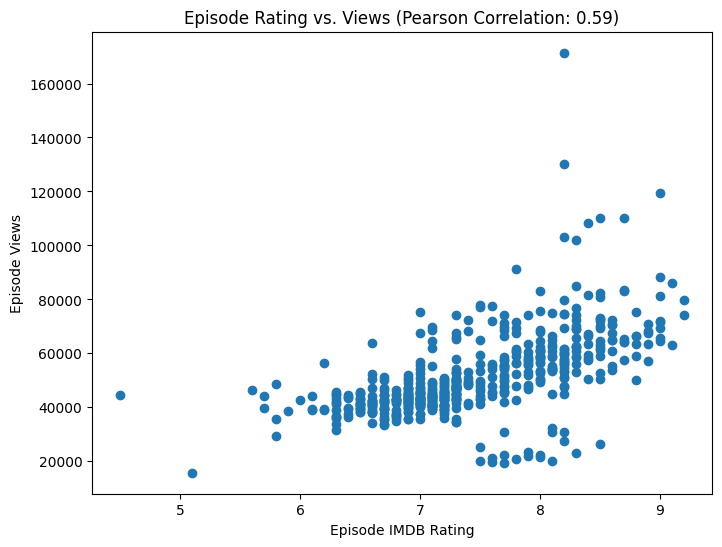

In [ ]:
analysis_code = response.text.replace("```python\n",'').replace("\n```",'')
exec(analysis_code)


## Para a avaliações do IMDB e da audiência dos episódios são apenas necessárias 2 colunas.

## 6 - Classificação de Sentimento com Few-Shot Learning

In [116]:
for text in data['normalized_text']:
    print(text)

no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows its only natural that you think you have it
wheres mr bergstrom
i dont know although id sure like to talk to him he didnt touch my lesson plan what did he teach you
that life is worth living
the polls will be open from now until the end of recess now just in case any of you have decided to put any thought into this well have our final statements martin
i dont think theres anything left to say
bart
victory party under the slide
nan
mr bergstrom mr bergstrom
hey hey he moved out this morning he must have a new job -- he took his copernicus costume
do you know where i could find him
i think hes taking the next train to capital city
the train how like him traditional yet environmentally sound
yes and its been the backbone of our country since leland stanford drove that golden spike at promontory point
i see he touched you too
nan
hey thanks for your vote man
i didnt vote votings for 

In [128]:
positivas = [
    "that life is worth living",
    "i am the champions i am the champions no time for losers cause i am the champions of the worlllld",
    "eh you must be bart simpson well you look like youve got a strong young back",
    "the polls will be open from now until the end",
    "victory party under the slide"
]

negativas = [
    "i dont think theres anything left to say",
    "we came to this retreat because i thought our marriage was in trouble but i never for a minute thought it was in this much trouble homer how can you expect me to believe",
    "oh thats my brother asa he was killed in the great war held a grenade too long",
    "hes gone forever",
    "you cant go youre the best teacher ill ever have"
]

neutras = [
    "wheres mr bergstrom",
    "would you have to do extra work",
    "oh please dad i want this more than anything in the world",
    "this way mister president",
    "how do i look"
]

episode_id = 92
episode_season = 5

X = (data[(data.episode_season == episode_season) &
          (data.episode_id == episode_id)].sort_values('number')
)
X = X.dropna(subset='normalized_text')

prompt = f"""
You are an expert in human communication and marketing, specialized in sentiment analysis.
You have to classify lines from a cartoon show as negative, neutral and positive as defined below:
- positive: happy, constructive, hopefull, joy and similar lines.
- negative: sad, destructive, hopeless, angressive and similar lines.
- neutral: indifferent, objetive, formal and lines classified neigher as positive or negative.

Some pre-classified lines from this show are listed here:

# Positive:
{ '- '.join(positivas) }


# Negative:
{ '- '.join(negativas) }


# Neutral:
{ '- '.join(neutras) }

Given this information, respond in JSON with the classification of these other lines as positive, negative or neutral. In this format:
line: ...
classification: ...


{ '- '.join(X.normalized_text.tolist()[:100]) }

"""

response = model.generate_content(prompt)
print(response.text)

```json
[
  {
    "line": "dad weve been robbed-",
    "classification": "negative"
  },
  {
    "line": "wake up dad wake up there was a burglar and he took my saxophone-",
    "classification": "negative"
  },
  {
    "line": "woo hoo-",
    "classification": "positive"
  },
  {
    "line": "and our portable tv-",
    "classification": "negative"
  },
  {
    "line": "and my necklace-",
    "classification": "negative"
  },
  {
    "line": "eh thats no big loss-",
    "classification": "neutral"
  },
  {
    "line": "homer that necklace was a priceless bouvier family heirloom-",
    "classification": "negative"
  },
  {
    "line": "oh youve probably got a whole drawer full of em-",
    "classification": "neutral"
  },
  {
    "line": "well yes i do but theyre all heirlooms too-",
    "classification": "neutral"
  },
  {
    "line": "the burglar even took my stamp collection-",
    "classification": "negative"
  },
  {
    "line": "you had a stamp collection-",
    "classification": 

Apenas 1 chamada ao LLm foi necessária

----

* Na parte negativa, o modelo foi bem acertivo.
* Na parte neutra, acredito o modelo ter errado a última fala.
* na parte positiva, foi boa.

~~~ 
    "line": "dad weve been robbed-",
    "classification": "negative"
    "line": "wake up dad wake up there was a burglar and he took my saxophone-",
    "classification": "negative"
    "line": "and our portable tv-",
    "classification": "negative"
    "line": "and my necklace-",
    "classification": "negative"
    "line": "homer that necklace was a priceless bouvier family heirloom-",
    "classification": "negative"

    "line": "eh thats no big loss-",
    "classification": "neutral"
    "line": "oh youve probably got a whole drawer full of em-",
    "classification": "neutral"
    "line": "well yes i do but theyre all heirlooms too-",
    "classification": "neutral"
    "line": "you had a stamp collection-",
    "classification": "neutral"
    "line": "shhh quiet lisa-",
    "classification": "neutral"
    
    "line": "woo hoo-",
    "classification": "positive"
    "line": "stamp collection haw haw-",
    "classification": "positive"
    "line": "hidilly ho neighboreenos-",
    "classification": "positive"
    "line": "ahhh aw man thats better-",
    "classification": "positive"
    "line": "ladies and gentlemen ladies and gentlemen please we have a major break in the case we recovered the burglars handkerchief from one of the crime scenes now one sniff of this baby and our tracking dog will be hot on his trail gosh look at me im sweating like a pig here-",
    "classification": "positive"

<Axes: xlabel='# falas', ylabel='Sentimento'>

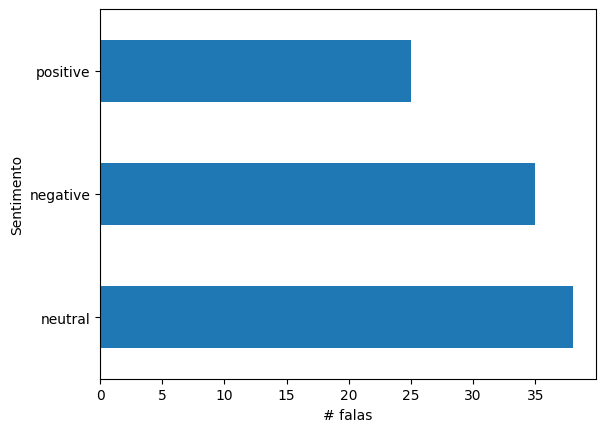

In [ ]:
classification_text = json.loads(response.text.replace("```json\n",'').replace("\n```",''))
classification_text = pd.DataFrame().from_dict(classification_text)
classification_text.columns = ['normalized_text', 'sentiment']
classification_text.sentiment.value_counts().plot.barh(xlabel='# falas', ylabel='Sentimento')

## 7 - Resumo Episódio

In [ ]:
prompt = f"""
O texto abaixo é um resumo do episódio de The Simpsons, o texto tem aproximadamente 500 tokens em português. Traduza o texto para inglês e mantenha o mesmo sentido do texto. Porém, é necessário que o texto tenha entre 450 e 500 tokens em inglês.
Apenas traduza o texto, não há necessidade de explicação.

## TEXTO
Em "O Gato Ladrão de Springfield", a família Simpson acorda após um assalto onde são roubados vários objetos, incluindo o saxofone de Lisa.  A polícia, inicialmente ineficaz, descobre que os roubos formam uma seta apontando para a delegacia. A mídia sensacionaliza o crime, e o pânico se instala na cidade.  A polícia encontra um lenço do ladrão, mas o cão farejador morde o policial.  Uma demonstração de um sistema de segurança de alta tecnologia falha. O Gato Ladrão, preso, implora por clemência.
Homer, escolhido para liderar uma patrulha de vizinhança, forma um grupo mal organizado e violento, causando mais danos do que prevenindo crimes.  A busca pelo ladrão se intensifica com o roubo de uma grande zircônia cúbica.  Marge liga para o Gato Ladrão, que se revela um comediante nervoso. O grupo de vigilantes de Homer age de forma desastrosa, e ele se frustra por não conseguir recuperar o saxofone de Lisa.  O avô Simpson, através de deduções perspicazes, identifica o Gato Ladrão como Molloy, morador de um asilo.
No confronto, Molloy é preso, mas revela o local de seu tesouro enterrado, causando correria generalizada na cidade.  A busca se prova infrutífera, revelando-se uma pegadinha de Molloy.  No final, o saxofone de Lisa é recuperado, e a família está reunida, com Homer tendo aprendido uma lição sobre responsabilidade. Molloy, apesar de ter sido preso, é considerado charmoso, e a família Simpson,  apesar do caos, consegue recuperar a maioria de seus pertences.  A cidade fica um tanto mais desorganizada e em pânico no final, mas com a alegria de Lisa de ter seu saxofone de volta.
"""

response = model.generate_content(prompt)
print(response.text)

In "The Springfield Cat Burglar," the Simpson family awakens to find their home ransacked, with numerous items stolen, including Lisa's saxophone. The initially ineffective police discover the robberies form an arrow pointing towards the police station. The media sensationalizes the crime, creating widespread panic in Springfield.  The police find a handkerchief belonging to the thief, but the K9 unit's police dog bites the officer instead of the suspect. A demonstration of a high-tech security system spectacularly fails. The Cat Burglar, apprehended briefly, pleads for leniency.

Homer, selected to lead a neighborhood watch patrol, assembles a poorly organized and violently inclined group, causing more damage than preventing crime.  The search for the thief intensifies with the theft of a large cubic zirconia. Marge makes a phone call to the Cat Burglar, who reveals himself to be a nervous comedian with a penchant for thievery. Homer's vigilante group operates disastrously, leaving hi

In [ ]:
text = estimar_tokens(response.text)
print(f"Quantidade de tokens: {len(text)}")


## O primeiro prompt deu uma uma quantidade de tokens de 338, muito longe de 500.. Refiz o prompt para aumentar a quantidade de tokens na tradução.

## --> Acrécimo no prompt: "Porém, é necessário que o texto tenha entre 450 e 500 tokens em inglês."
## Foi para 539, não ficou exatamente no range listado, mas bem mais próximo do prompt anterior.

Quantidade de tokens: 539


## 8 - Resumos Complexos com Chunks de Texto

In [ ]:
## Retirei alguns pontos dos prompts

class ChunkSummary():
    def __init__(self, model_name, apikey, text, window_size, overlap_size):
        self.text = text
        if isinstance(self.text, str):
            self.text = [self.text]
        self.window_size = window_size
        self.overlap_size = overlap_size
        # Aplicacao dos chunks
        self.chunks = self.__text_to_chunks()
        self.model = self.__create_model(apikey, model_name)


    def __create_model(self, apikey, model_name):
        genai.configure(api_key=apikey)
        self.prompt_base = f"""
        You are an editor assistant from the "The Simpsons" show.
        You will receive the #subtitles# from real episodes in the format:
        <location>, <character> said: <character line>
        
        You must create a summary of the #subtitles#, pointing out the most
        relevant information and key players in the story. Bare in mind
        that the summary must describe how the episode started, which key
        points are relevant along the story and its gran finale.
        The summary output must be written as a plain JSON with field 'summary'.
        """
        safety_settings={
            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
        }
        generation_config = {
            'temperature': 0.2,
            'top_p': 0.8,
            'top_k': 20,
            'max_output_tokens': 1000
        }
        return genai.GenerativeModel(
            model_name,
            system_instruction=self.prompt_base,
            generation_config = generation_config,
            safety_settings=safety_settings
        )


    
    def __text_to_chunks(self):       
        n = self.window_size  # Tamanho de cada chunk
        m = self.overlap_size  # overlap entre chunks
        return [self.text[i:i+n] for i in range(0, len(self.text), n-m)]


    def __create_chunk_prompt(self, chunk):
        episode_lines = '\n'.join(chunk)
        prompt = f"""
        #subtitles#
        {episode_lines}
        ######
        Summarize it.
        """
        return prompt
        
    
    def __summarize_chunks(self):
        # Loop over chunks
        chunk_summaries = []
        for i, chunk in enumerate(self.chunks):
            print(f'Summarizing chunk {i+1} from {len(self.chunks)}')
            # Create prompt
            prompt = self.__create_chunk_prompt(chunk)
            response = self.model.generate_content(prompt)
            print(response.text)
            print("")
            # Apendar resposta do chunk
            chunk_summaries.append(response.text)
            
            # if i == 4: break

        return chunk_summaries


    def summarize(self):
        print('Summarizing text')
        # Chamar o sumario dos chunks
        self.chunk_summaries = self.__summarize_chunks()
        # Prompt final
        summaries = '- ' + '\n- '.join(self.chunk_summaries)
        prompt = f"""
        You are an editor working on The Simpsons show. You must summarize
        a show episode considering the other summaries from part of the episode.
        The partitioned summaries are listed below:
        {summaries}
        ######
        The summary must describe the story in general and details
        on what happens in the end with the key characters.
        Write a final summary based on the partitioned summaries in JSON format with
        the field 'summary'.
        """
        print('Final summarization')
        response = self.model.generate_content(prompt)
        
        return response.text
    

    def bleu_metrics(self):
        bleu_metric_chunk_summaries = []
        return "A"
        # for chunk in self.chunks:
        #     prompt = self.__create_chunk_prompt(chunk)
        #     response = self.model.generate_content(prompt)

        #     summmary = json.loads(response.text.replace("```json\n",'').replace("\n```",''))

        #     bleu_scorer = BLEU()
        #     score_bleu = bleu_scorer.sentence_score(
        #     hypothesis=summmary['summary'],
        #     references=[REFERENCE],
        #     )
        #     print(score_bleu.score)

            # bleu_metric_chunk_summaries.append(score_bleu.score/100)
            
            # if i == 4: break

        # return bleu_metric_chunk_summaries

In [ ]:
episode_id = 92
episode_season = 5

X = (data[(data.episode_season == episode_season) &
          (data.episode_id == episode_id)].sort_values('number')
)

X['line'] = (X['location_normalized_name'].fillna('') + ', ' + 
             X['character_normalized_name'].fillna('') + ' said: ' + 
             X['normalized_text'].fillna('')
)


summarizer = ChunkSummary(
    model_name = "gemini-1.5-flash",
    apikey = google_api_key,
    text = X['line'].tolist(),
    window_size = 100,
    overlap_size = 25
)

episode_summary = summarizer.summarize()

In [ ]:
final_summmary = json.loads(episode_summary.replace("```json\n",'').replace("\n```",''))
print(final_summmary)

##{'summary': "The Simpsons episode revolves around a series of thefts in Springfield, starting with the robbery of Lisa's saxophone, Bart's stamp collection, and Marge's necklace.  This sparks a town-wide panic and a largely ineffective investigation by Chief Wiggum.  Homer Simpson, unexpectedly elected head of the neighborhood watch, forms a chaotic and poorly trained group that inadvertently increases crime rates rather than decreasing them.  Their antics lead to several humorous confrontations and misadventures.  Meanwhile, the real culprit, Molloy, a resident of the Springfield Retirement Castle, is eventually apprehended by Grandpa Simpson.  Molloy charmingly confesses and returns the stolen items, but is still arrested by Chief Wiggum.  Molloy's confession leads to a town-wide treasure hunt for his remaining loot, which proves ultimately unsuccessful.  The episode concludes with a comedic depiction of the town's continued search for the treasure and Homer's self-congratulatory delusion despite the overall chaos and ineffectiveness of the neighborhood watch and the treasure hunt.  Key players include Homer, Marge, Lisa, Grandpa Simpson, Chief Wiggum, and Molloy, the cat burglar."}


## --> Foram necessários, 4 chunks --> 100 para 25. No geral, o resumo traz exatamente a história, com os pontos importantes e os personagens, ao final ele cita os participantes principais do episódio. Ajustes no prompt fizeram com que diminuísse o tamanho do resumo e consequentemente os seus tokens. O resultado final e os chunks são bem definidos e coesos.

text = estimar_tokens(episode_summary)
print(f"Quantidade de tokens: {len(text)}")

## 9 - Avaliação de Resumos de LLMs

In [68]:
from sacrebleu.metrics import BLEU
from sacrebleu import sentence_bleu
bleu_scorer = BLEU()    


reference_my_resume = response.text
hypothesis_final_summary = final_summmary['summary']

score_bleu = bleu_scorer.sentence_score(
    hypothesis=hypothesis_final_summary,
    references=[reference_my_resume],
)

score_bleu.score/100   

# bleu = sentence_bleu(hypothesis_final_summary, reference_my_resume)
# print(bleu.score/ 100)


## O resultado nas 2 formas é praticamente igual.


# bleuasa = summarizer.bleu_metrics()
# bleuasa

It is recommended to enable `effective_order` for sentence-level BLEU.


0.04458794313120763

In [45]:
from rouge import Rouge
rouge_scorer = Rouge()

reference_my_resume = response.text
hypothesis_final_summary = final_summmary['summary']

score_rouge = rouge_scorer.get_scores(
    hyps=hypothesis_final_summary,
    refs=reference_my_resume,
)
print('ROUGE-L-F', score_rouge[0]["rouge-l"]["f"])
print('ROUGE-L-R', score_rouge[0]["rouge-l"]['r'])
print('ROUGE-L-P', score_rouge[0]["rouge-l"]['p'])

ROUGE-L-F 0.24870465861848645
ROUGE-L-R 0.1935483870967742
ROUGE-L-P 0.34782608695652173
